# Problem Statement

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The data set contains the following diseases:

* Actinic keratosis
* Basal cell carcinoma
* Dermatofibroma
* Melanoma
* Nevus
* Pigmented benign keratosis
* Seborrheic keratosis
* Squamous cell carcinoma
* Vascular lesion




### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
# intalling this package as it not preset in colab runtime
!pip install Augmentor

In [2]:
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os
import PIL
import shutil
import Augmentor
import glob
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
# This is absolute path to my persional kaggle data assets. 
# Using Kaggle here as google does not have a good servise on colab

data_dir_train = pathlib.Path("/kaggle/input/skin-cancer-dataset/CNN_assignment/Skin cancer types/Train")
data_dir_test = pathlib.Path("/kaggle/input/skin-cancer-dataset/CNN_assignment/Skin cancer types/Test")

print("Train Directory Exists: {}, with train file count as: {}".format(data_dir_train.exists(), len(list(data_dir_train.glob("*/*")))))
print("test Directory Exists: {}, with test file count as: {}".format(data_dir_test.exists(), len(list(data_dir_test.glob("*/*")))))


# Importing the above data to working directories to make changes in the dataset in upcomming stages
working_train_dir = pathlib.Path("/kaggle/working/Train")
working_test_dir = pathlib.Path("/kaggle/working/Test")

shutil.copytree(data_dir_train, working_train_dir, dirs_exist_ok=True)
shutil.copytree(data_dir_test, working_test_dir, dirs_exist_ok=True)

print("Data copied to working directory!")

# Updating the directory 
data_dir_train = pathlib.Path("/kaggle/working/Train")
data_dir_test = pathlib.Path("/kaggle/working/Test")

Train Directory Exists: True, with train file count as: 2239
test Directory Exists: True, with test file count as: 118
Data copied to working directory!


In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train) #2239
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test) #118

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset = "training",
    image_size=(img_height, img_width),
    batch_size=batch_size
)


validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset = "validation",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print('Class Names:',class_names)
target_labels = len(class_names)
print('No of Targets:',target_labels)

Class Names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
No of Targets: 9


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

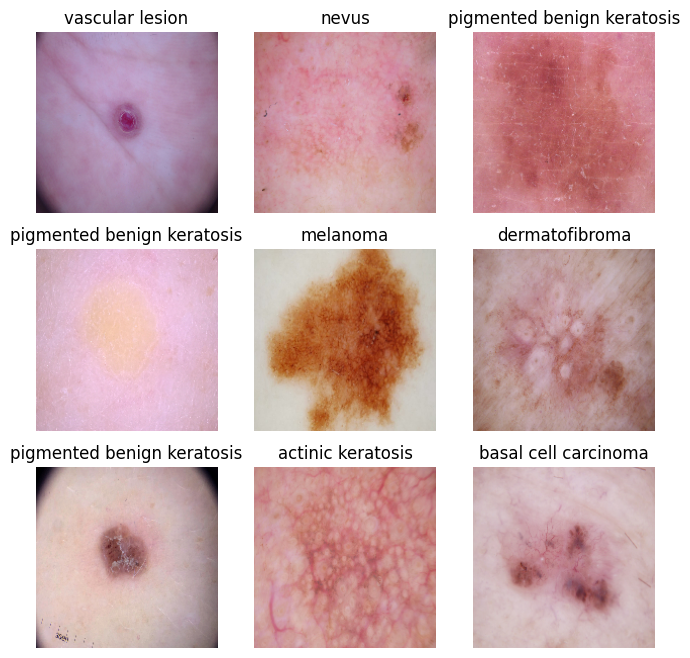

In [8]:
### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(8,8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

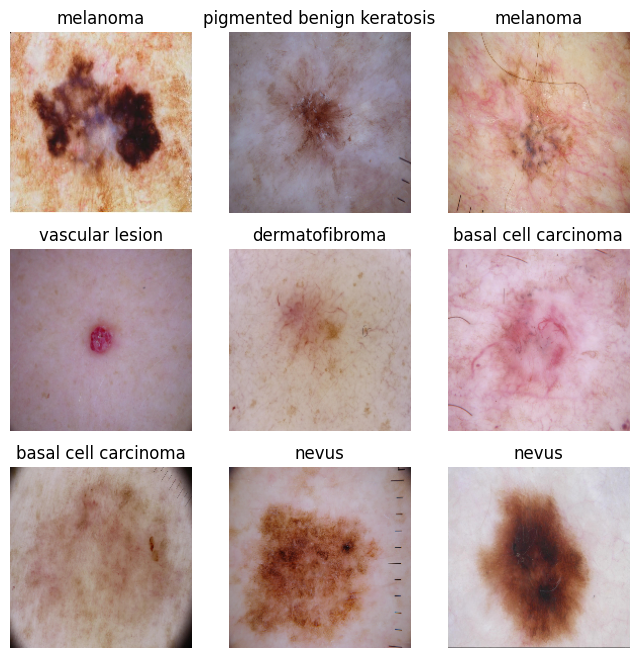

In [9]:
# Visualizing validation dataset
plt.figure(figsize=(8, 8))
for images, labels in validation_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


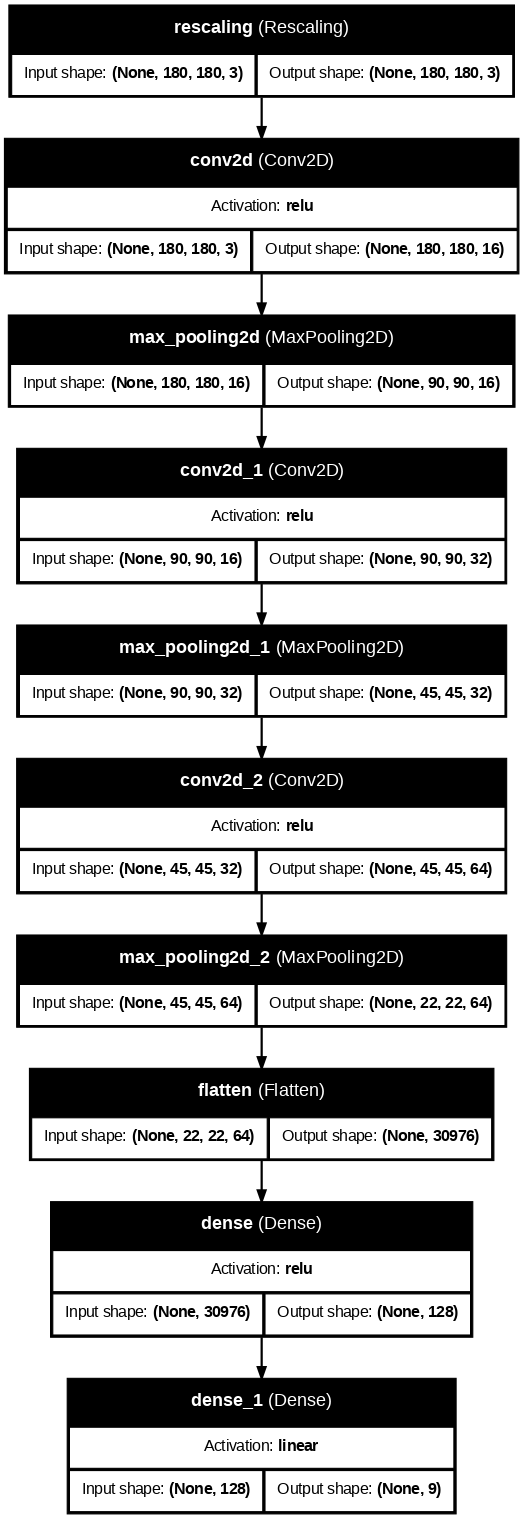

In [11]:
### Your code goes here

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

#model visualization
plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True, show_layer_activations=True, dpi=80)



### Compile the model
Choose an appropirate optimiser and loss function for model training

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary(show_trainable=True, )

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ rescaling (Rescaling)               │ (None, 180, 180, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d (Conv2D)                     │ (None, 180, 180, 16)         │           448 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling2d (MaxPooling2D)        │ (None, 90, 90, 16)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_1 (Conv2D)                   │ (None, 90, 90, 32)           │         4,640 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling2d_1 (MaxPooling2D)      │ (None, 45, 45, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_2 (Conv2D)                   │ (None, 45, 45, 64)           │        18,496 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling2d_2 (MaxPooling2D)      │ (None, 22, 22, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ flatten (Flatten)                   │ (None, 30976)                │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 128)                  │     3,965,056 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_1 (Dense)                     │ (None, 9)                    │         1,161 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - accuracy: 0.2551 - loss: 2.0306 - val_accuracy: 0.4519 - val_loss: 1.6079
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4705 - loss: 1.5130 - val_accuracy: 0.5213 - val_loss: 1.4490
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5199 - loss: 1.3743 - val_accuracy: 0.5436 - val_loss: 1.4140
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5400 - loss: 1.2659 - val_accuracy: 0.5436 - val_loss: 1.3907
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5822 - loss: 1.1858 - val_accuracy: 0.5436 - val_loss: 1.4652
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6116 - loss: 1.1008 - val_accuracy: 0.5190 - val_loss: 1.4296
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6275 - loss: 1.0181 - val_accuracy: 0.5347 - val_loss: 1.4591
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6882 - loss: 0.8801 - val_accuracy: 0.5369 - 

### Visualizing training results

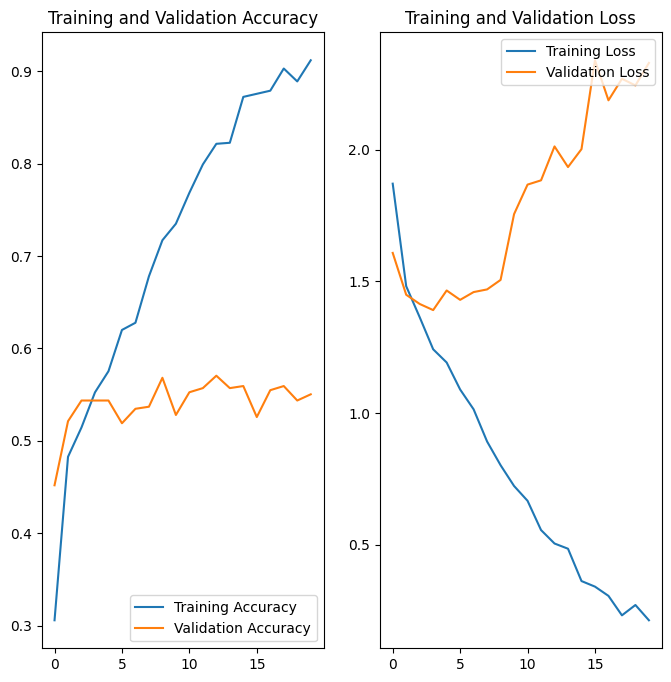

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
* Model training accuracy increase steadity upto 90%, but validation accuracy went up to 50% but stopped increasing from there.
* Its clear that model was able to perform nicely on seen data but when it comes to un-seen data data it didn't performed nicely. It looks like it overfitting on the seen data.
* This issue can also come due to the presence of less datasets, to tackle this issue we will try to introduece new data assets but slighlty modifing(Flipping the existing images or minor image rotation or random zoom) the existing datasets.

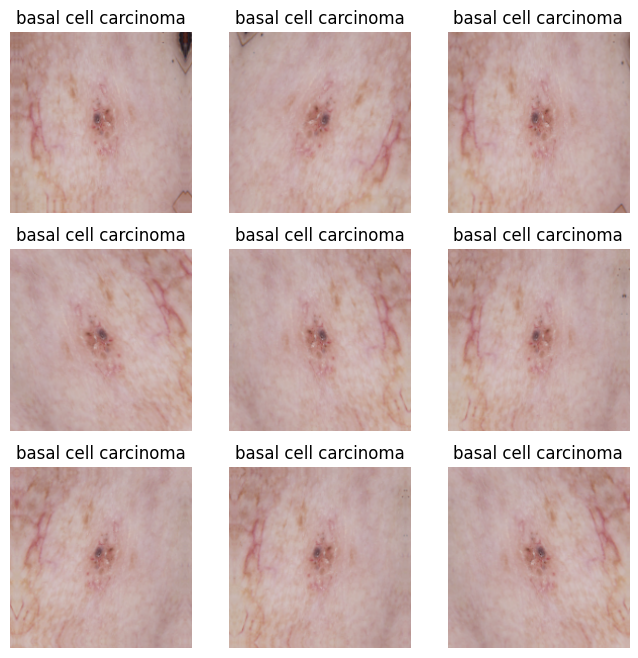

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
augmentation_data = keras.Sequential([
                        layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                        layers.RandomRotation(0.1),
                        layers.RandomZoom(0.1),
])

# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [17]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),   # Added Dropout layer here
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),  # Added Dropout layer here
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])


### Compiling the model

In [18]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [19]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.2026 - loss: 2.5864 - val_accuracy: 0.1723 - val_loss: 2.0747
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.2277 - loss: 2.0142 - val_accuracy: 0.2752 - val_loss: 1.9459
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.3288 - loss: 1.8775 - val_accuracy: 0.3266 - val_loss: 1.8505
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4000 - loss: 1.6961 - val_accuracy: 0.4653 - val_loss: 1.6516
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4570 - loss: 1.5460 - val_accuracy: 0.4922 - val_loss: 1.5468
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4436 - loss: 1.5684 - val_accuracy: 0.4832 - val_loss: 1.5089
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5096 - loss: 1.4538 - val_accuracy: 0.5123 - val_loss: 1.4652
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5095 - loss: 1.4256 - val_accuracy: 0.4922 - v

### Visualizing the results

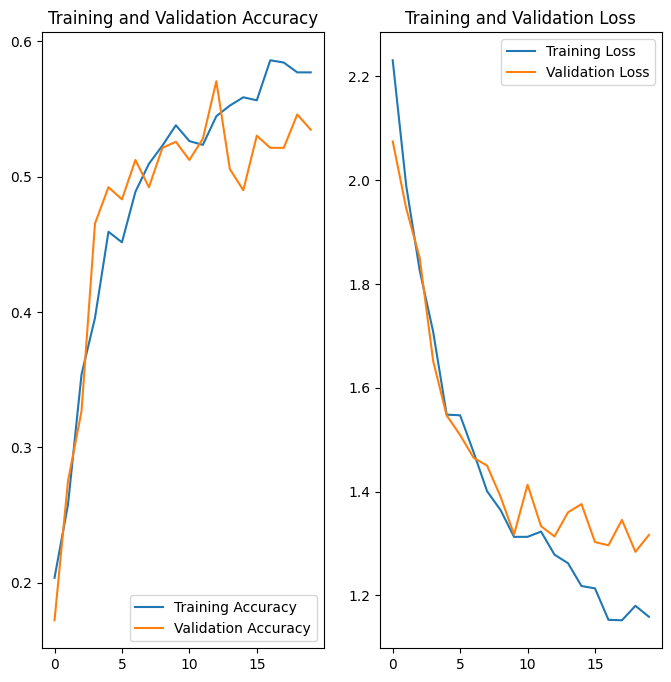

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [21]:
## Your code goes here.
from glob import glob

## find the image path for all class labels (lesions)
images_path_list = [ i for i in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]

## Extract the class labels (lesions)
lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesions_list))

2239


In [22]:
# Extract image path and class label in a dictionary
image_dict = dict(zip(images_path_list, lesions_list))
print(list(image_dict.items())[:5]) #Dict visualization

# View the image path and class label in a df
lesions_df = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
lesions_df.head()

[('/kaggle/working/Train/nevus/ISIC_0000042.jpg', 'nevus'), ('/kaggle/working/Train/nevus/ISIC_0000448.jpg', 'nevus'), ('/kaggle/working/Train/nevus/ISIC_0028063.jpg', 'nevus'), ('/kaggle/working/Train/nevus/ISIC_0000224.jpg', 'nevus'), ('/kaggle/working/Train/nevus/ISIC_0000416.jpg', 'nevus')]


,Image Path,Label
0,/kaggle/working/Train/nevus/ISIC_0000042.jpg,nevus
1,/kaggle/working/Train/nevus/ISIC_0000448.jpg,nevus
2,/kaggle/working/Train/nevus/ISIC_0028063.jpg,nevus
3,/kaggle/working/Train/nevus/ISIC_0000224.jpg,nevus
4,/kaggle/working/Train/nevus/ISIC_0000416.jpg,nevus


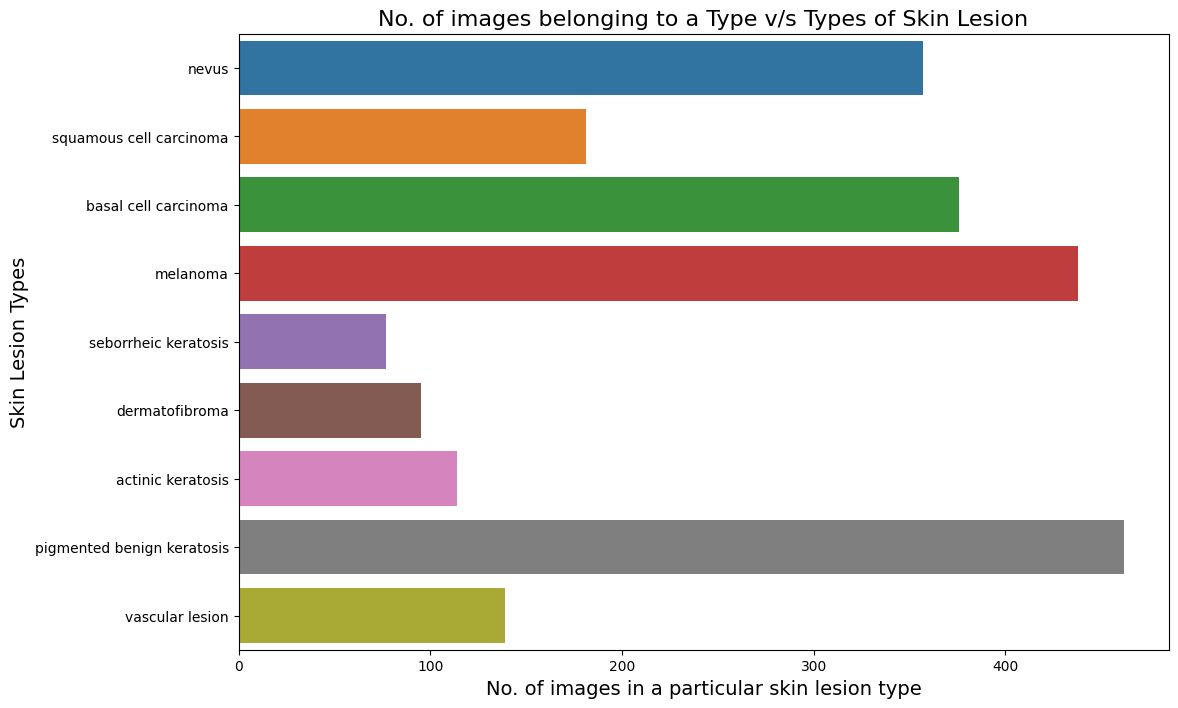

In [23]:
# Data Visualization of sample miss-match
plt.figure(figsize=(12, 8))
sns.countplot(y="Label", data=lesions_df)
plt.title('No. of images belonging to a Type v/s Types of Skin Lesion', fontsize=16)
plt.xlabel('No. of images in a particular skin lesion type', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


* Observation
1. From the above graph its clear that there is a class imbalance in the data that needs to be addressed.
2. ``seborrheic keratosis`` has the list amount of data where as ``melanoma`` and ``Pigmented benign keratosis`` has high data samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [24]:
for i in class_names:
    class_path = os.path.join(data_dir_train, i)
    p = Augmentor.Pipeline(class_path)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B081E49FCD0>: 100%|██████████| 500/500 [00:06<00:00, 78.21 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /kaggle/working/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B081E2E2DA0>: 100%|██████████| 500/500 [00:05<00:00, 83.51 Samples/s] 


Initialised with 95 image(s) found.
Output directory set to /kaggle/working/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B08ABC25000>: 100%|██████████| 500/500 [00:06<00:00, 81.93 Samples/s]                   


Initialised with 438 image(s) found.
Output directory set to /kaggle/working/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=824x719 at 0x7B081E49D9F0>: 100%|██████████| 500/500 [00:36<00:00, 13.87 Samples/s]  


Initialised with 357 image(s) found.
Output directory set to /kaggle/working/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7B081E387820>: 100%|██████████| 500/500 [00:31<00:00, 15.82 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /kaggle/working/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B081E67F0A0>: 100%|██████████| 500/500 [00:05<00:00, 88.50 Samples/s]                   


Initialised with 77 image(s) found.
Output directory set to /kaggle/working/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B081E51B3D0>: 100%|██████████| 500/500 [00:14<00:00, 35.08 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to /kaggle/working/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B081E67C250>: 100%|██████████| 500/500 [00:05<00:00, 84.52 Samples/s]                   


Initialised with 139 image(s) found.
Output directory set to /kaggle/working/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B081E637220>: 100%|██████████| 500/500 [00:05<00:00, 83.86 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [25]:

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [26]:
import glob
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

['/kaggle/working/Train/nevus/output/nevus_original_ISIC_0000494.jpg_e5be15a6-8191-4e07-81d1-5c43e6761364.jpg',
 '/kaggle/working/Train/nevus/output/nevus_original_ISIC_0025780.jpg_49f31c60-c6a1-42e9-8789-8ac62a20e57d.jpg',
 '/kaggle/working/Train/nevus/output/nevus_original_ISIC_0000392.jpg_a4f28371-b973-4e1d-9a76-63b1af0bf808.jpg',
 '/kaggle/working/Train/nevus/output/nevus_original_ISIC_0000380.jpg_b29724ed-7bd3-47b6-97cf-29f07627e3e7.jpg',
 '/kaggle/working/Train/nevus/output/nevus_original_ISIC_0000094.jpg_c5ca1c65-0418-4999-b764-46b766cf7016.jpg']

In [27]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['nevus', 'nevus', 'nevus', 'nevus', 'nevus']

In [28]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [29]:
# Joining the old data set and newly created dataset in a single dataset
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Image Path','Label'])
new_df = pd.concat([lesions_df, df2], ignore_index=True)
new_df.shape

(6739, 2)

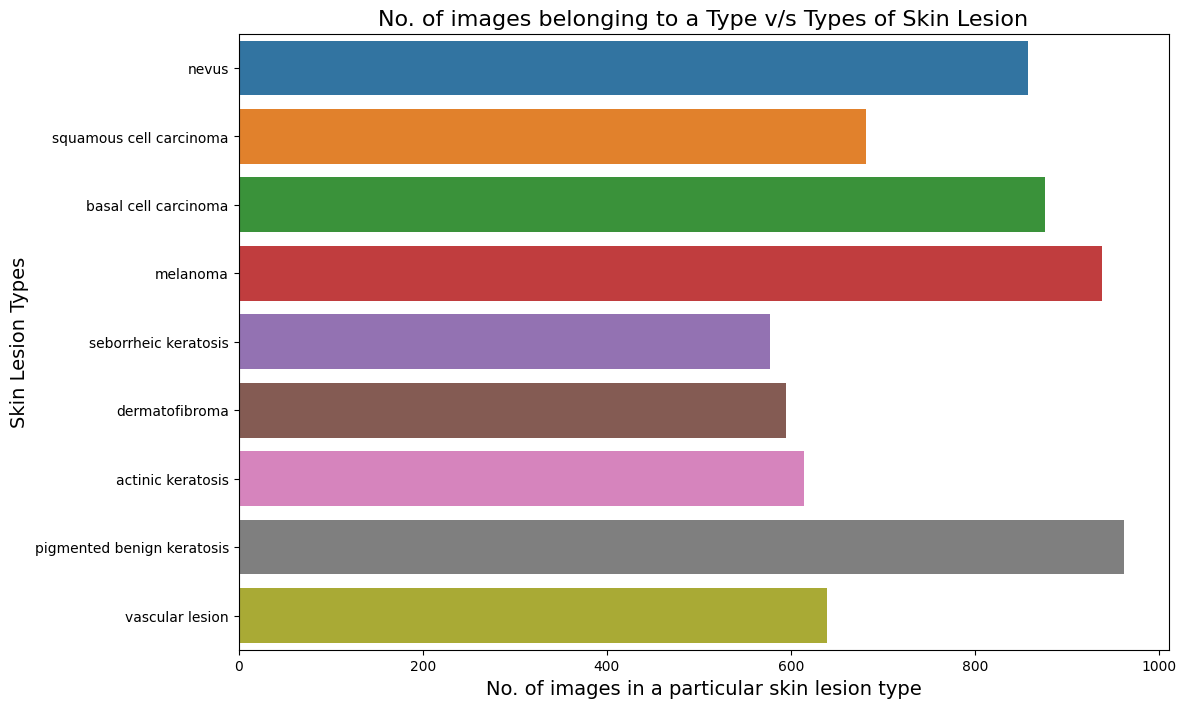

In [30]:
# Data Visualization aftger sample miss-match fix using Augmentor
plt.figure(figsize=(12, 8))
sns.countplot(y="Label", data=new_df)
plt.title('No. of images belonging to a Type v/s Types of Skin Lesion', fontsize=16)
plt.xlabel('No. of images in a particular skin lesion type', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [31]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training and vaidation dataset

In [32]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)


validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [33]:
## your code goes here

model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

In [34]:
model.summary(show_trainable=True,)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ sequential_1 (Sequential)           │ (None, 180, 180, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ rescaling_2 (Rescaling)             │ (None, 180, 180, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_6 (Conv2D)                   │ (None, 180, 180, 16)         │           448 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization                 │ (None, 180, 180, 16)         │            64 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling2d_6 (MaxPooling2D)      │ (None, 90, 90, 16)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_7 (Conv2D)                   │ (None, 90, 90, 32)           │         4,640 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization_1               │ (None, 90, 90, 32)           │           128 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling2d_7 (MaxPooling2D)      │ (None, 45, 45, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_8 (Conv2D)                   │ (None, 45, 45, 64)           │        18,496 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_normalization_2               │ (None, 45, 45, 64)           │           256 │    Y    │
│ (BatchNormalization)                │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling2d_8 (MaxPooling2D)      │ (None, 22, 22, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_2 (Dropout)                 │ (None, 22, 22, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ flatten_2 (Flatten)                 │ (None, 30976)                │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_4 (Dense)                     │ (None, 128)                  │     3,965,056 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_5 (Dense)                     │ (None, 9)                    │         1,161 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 3,990,249 (15.22 MB)

 Trainable params: 3,990,025 (15.22 MB)

 Non-trainable params: 224 (896.00 B)

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [35]:
## your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# using checkpoint to save the best model
checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
# Usinf earlystop to stop the model if it stops to progress
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

#### **Todo:**  Train your model

In [36]:
epochs = 50
## Your code goes here, use 50 epochs. Using checkpoint and earlystop to keep model less complicated
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs,
  callbacks=[checkpoint, earlystop]
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3025 - loss: 3.5925
Epoch 1: val_accuracy improved from -inf to 0.10839, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 15s 71ms/step - accuracy: 0.3027 - loss: 3.5843 - val_accuracy: 0.1084 - val_loss: 21.4600
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4104 - loss: 1.5165
Epoch 2: val_accuracy improved from 0.10839 to 0.17743, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.4103 - loss: 1.5166 - val_accuracy: 0.1774 - val_loss: 9.0222
Epoch 3/50
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4500 - loss: 1.4470
Epoch 3: val_accuracy improved from 0.17743 to 0.25538, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.4499 - loss: 1.4471 - val_accuracy: 0.2554 - val_loss: 3.3805
Epoch 4/50
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4874 - loss: 1.3388
Epoch 4: val_accuracy improved from 0.25538 t

#### **Todo:**  Visualize the model results

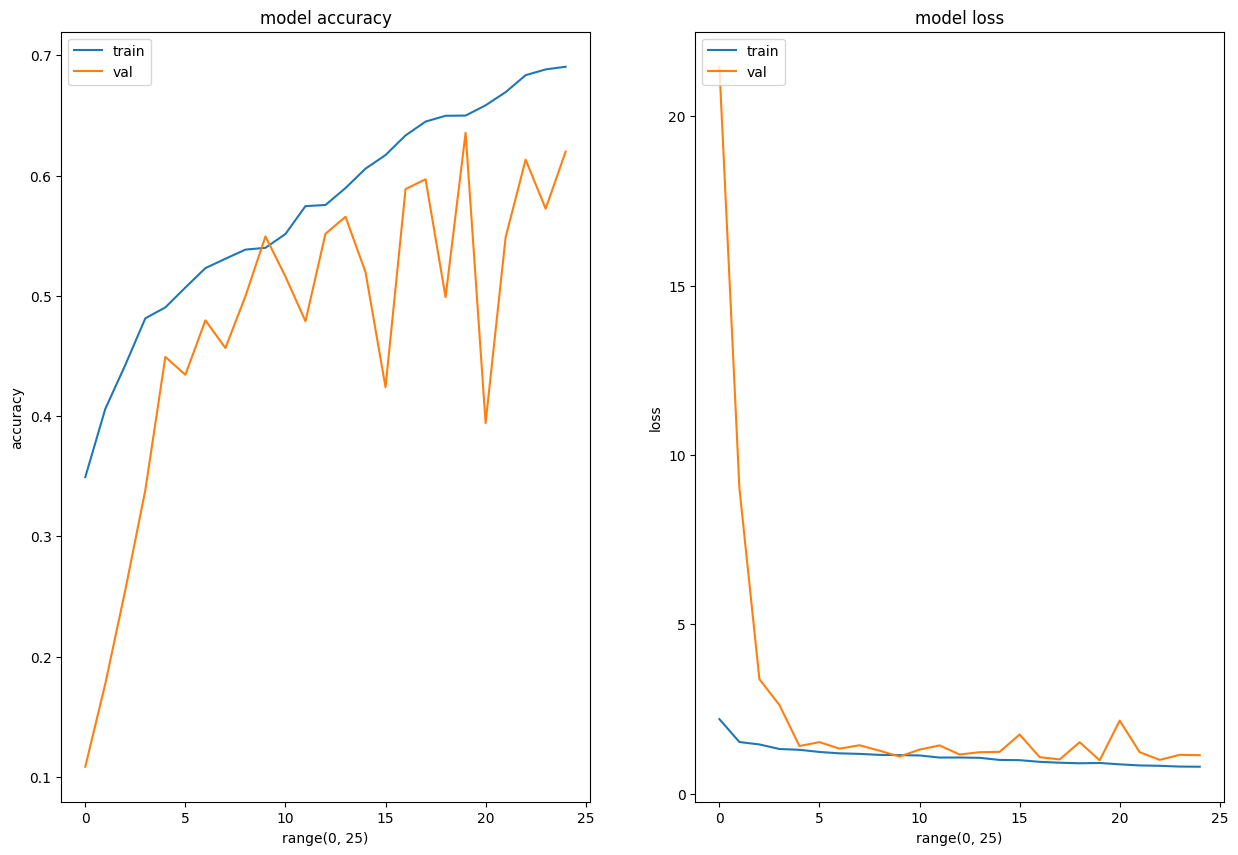

In [37]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



* Implemeting batch normalization didn't made the modelany better, it added random uptick in both training and validation accuracy.
* Main goal of this mapdel was to investigate prospective improvements in accuracy which it didn't gave.
* Creating an anothher model with out normalization


#### **Todo:** Create your model (without including normalization)

In [38]:
# create the model with out normalization
model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

In [39]:
model.summary(show_trainable=True,)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ sequential_1 (Sequential)           │ (None, 180, 180, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ rescaling_3 (Rescaling)             │ (None, 180, 180, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_9 (Conv2D)                   │ (None, 180, 180, 16)         │           448 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling2d_9 (MaxPooling2D)      │ (None, 90, 90, 16)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_10 (Conv2D)                  │ (None, 90, 90, 32)           │         4,640 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling2d_10 (MaxPooling2D)     │ (None, 45, 45, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2d_11 (Conv2D)                  │ (None, 45, 45, 64)           │        18,496 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pooling2d_11 (MaxPooling2D)     │ (None, 22, 22, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout_3 (Dropout)                 │ (None, 22, 22, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ flatten_3 (Flatten)                 │ (None, 30976)                │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_6 (Dense)                     │ (None, 128)                  │     3,965,056 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_7 (Dense)                     │ (None, 9)                    │         1,161 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
## your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# using checkpoint to save the best model
checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
# Usinf earlystop to stop the model if it stops to progress
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

In [41]:
epochs = 50
## Your code goes here, use 50 epochs. Using checkpoint and earlystop to keep model less complicated
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs,
  callbacks=[checkpoint, earlystop]
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.1472 - loss: 2.3145
Epoch 1: val_accuracy improved from -inf to 0.31700, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.1474 - loss: 2.3133 - val_accuracy: 0.3170 - val_loss: 1.7864
Epoch 2/50
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3860 - loss: 1.6193
Epoch 2: val_accuracy improved from 0.31700 to 0.43727, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.3863 - loss: 1.6186 - val_accuracy: 0.4373 - val_loss: 1.4545
Epoch 3/50
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4408 - loss: 1.4523
Epoch 3: val_accuracy improved from 0.43727 to 0.48998, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.4409 - loss: 1.4521 - val_accuracy: 0.4900 - val_loss: 1.3720
Epoch 4/50
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4814 - loss: 1.3357
Epoch 4: val_accuracy improved from 0.48998 to

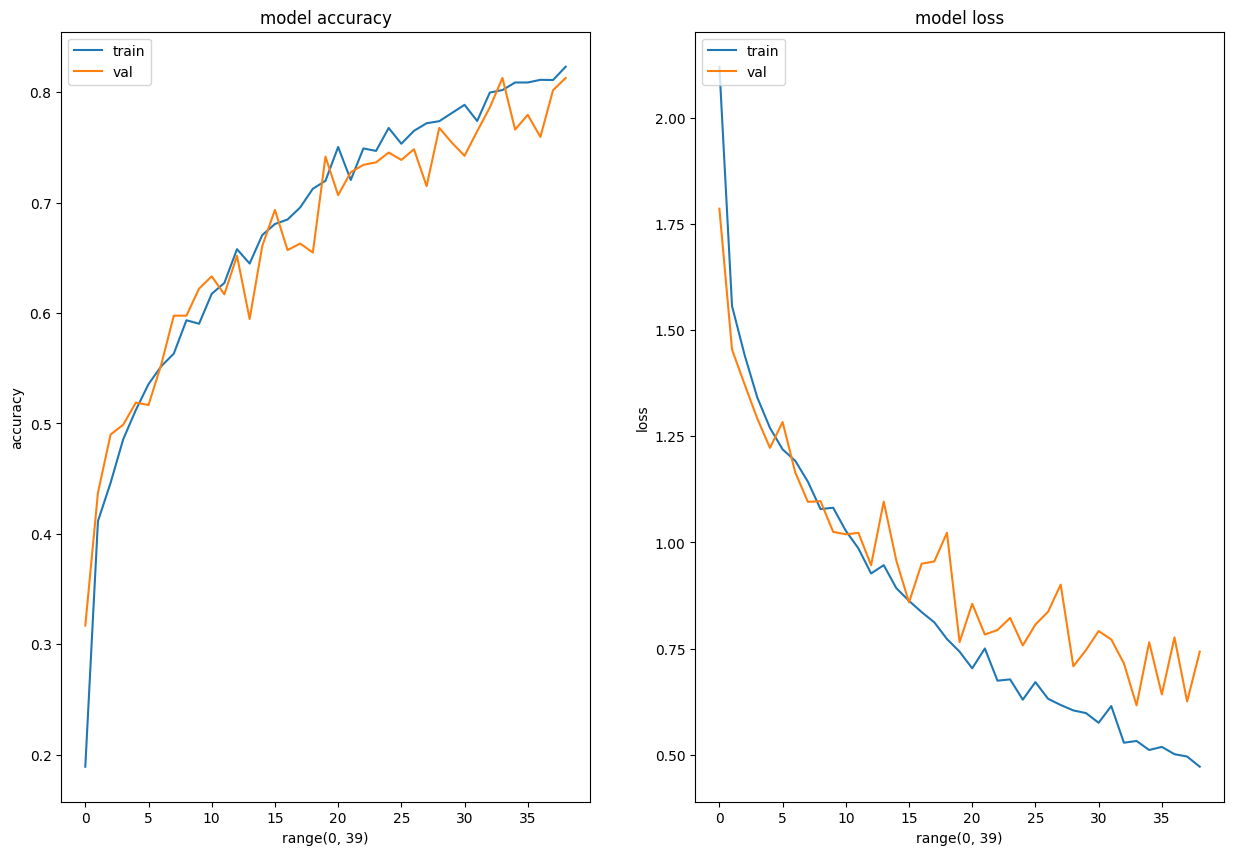

In [42]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

Observations:
1. Model with out Normalization gave a well balanced output, displaying no sign of overfitting.
2. Implementation of calls imbalance improvend the accuracy by a lot.
3. Batch Normalization didn't' give a good result.
4. Final model is giving 80%-85% accuracy in training data where as aroung 75-80%% accuracy on validation data which is a good number.
